In [119]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections
import random


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen = capacity)
    
    def add(self, state, action, reward, next_state, terminated):
        self.buffer.append((state, action, reward, next_state, terminated))

    def sample(self, batch_size):
        items = random.sample(self.buffer, batch_size)
        return zip(*items)

    def size(self):
        return len(self.buffer)
    
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, action_dim)
        )
        self.state_dim = state_dim
        self.action_dim = action_dim

    def forward(self, x):
        assert(2 == len(x.shape) and x.shape[1] == self.state_dim)
        return self.net(x)



class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        self.count = 0

    def take_action(self, state):
        #assert(len(state.shape) == 2 and state.shape[1] == self.state_dim)
        #assert(state.shape==(1,self.state_dim))
        assert(len(state)  == self.state_dim)
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            action = self.q_net(torch.tensor([state])).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def get_max_next_q_values(self, next_states):
        return self.q_net(next_states).max(1)[0].view(-1, 1)
    
    def update(self, states, actions, rewards, next_states, terminateds):
        states = torch.tensor(states,dtype=torch.float).to(self.device)
        actions = torch.tensor(actions,dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(rewards,dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(next_states,dtype=torch.float).to(self.device)
        terminateds = torch.tensor(terminateds,dtype=torch.float).view(-1, 1).to(self.device)

        #print(states.shape, actions.shape, rewards.shape, next_states.shape, terminateds.shape)

        q_values = self.q_net(states).gather(1, actions)
        #print(q_values.shape)
        max_next_q_values = self.get_max_next_q_values(next_states)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - terminateds)

        loss = torch.nn.functional.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


class DoubleDQN(DQN):
    #def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
    #    super().__init__()
    def get_max_next_q_values(self, next_states):
        #print(next_states.shape)
        max_next_actions = self.q_net(next_states).argmax(1).view(-1,1)
        #print(next_states.shape, max_next_actions.shape)
        max_next_q_values = self.target_net(next_states).gather(1, max_next_actions)
        #print(next_states.shape, max_next_actions.shape,max_next_q_values.shape)
        return max_next_q_values


lr = 1e-2
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cpu") #torch.device("cuda") if torch.cuda.is_available () else torch.device("cpu")
env_name = "Pendulum-v1"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 100#env.action_space.n
env.close()

def dis_to_con(discrete_action, env, action_dim):
    low = env.action_space.low[0]
    high = env.action_space.high[0]
    return low + discrete_action * (high - low) / (action_dim - 1)
    
def train(agent, num_episodes):
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    replay_buffer = ReplayBuffer(buffer_size)
    reward_stat = np.zeros(num_episodes)
    q_value_stat = [] 
    env = gym.make(env_name)
    for episode in range(num_episodes):
        state, info = env.reset(seed=0)
        total_reward = 0
        while True:
            q_value_stat.append(agent.max_q_value(state))
            action = agent.take_action(state)
            continuous_action = dis_to_con(action, env, agent.action_dim)
            next_state, reward, terminated, truncated, info = env.step([continuous_action])
            replay_buffer.add(state, action, reward, next_state, terminated)
            state = next_state
            total_reward += reward
            if replay_buffer.size() > minimal_size:
                states, actions, rewards, next_states, terminateds = replay_buffer.sample(batch_size)
                agent.update(states, actions, rewards, next_states, terminateds)
            if terminated or truncated:
                break
        if episode*10 % num_episodes == 0:
            print("episode:", episode, "total_reward:",total_reward)
        reward_stat[episode] = total_reward
    env.close()
    return reward_stat, q_value_stat

def test(agent, num_episodes):
    env = gym.make(env_name,render_mode="human")
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            continuous_action = dis_to_con(action, env, agent.action_dim)
            next_state, reward, terminated, truncated, info = env.step([continuous_action])
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        #print("episode:", episode, "total_reward:",total_reward)
    env.close()


def moving_average(nums, n):
    beta = 1 - 1.0/n
    alpha = 1.0 - beta
    avg = nums[0]
    res = np.zeros_like(nums)
    for n in range(len(nums)):
        avg = avg * beta + nums[n]*alpha
        res[n] = avg
    return res


episode: 0 total_reward: -1242.9560374920618
episode: 50 total_reward: -1059.117671018355
episode: 100 total_reward: -1309.4800601691759
episode: 150 total_reward: -854.7568646439164
episode: 200 total_reward: -1383.499640582102
episode: 250 total_reward: -1067.0734365810133
episode: 300 total_reward: -1017.2157490328757
episode: 350 total_reward: -1496.0699447716986
episode: 400 total_reward: -1585.7484657084317
episode: 450 total_reward: -1049.4078441703953
episode: 0 total_reward: -1242.9560374920618
episode: 50 total_reward: -254.28359557150785
episode: 100 total_reward: -903.5519877170801
episode: 150 total_reward: -250.83082277343064
episode: 200 total_reward: -128.6469546224249
episode: 250 total_reward: -126.48469958768963
episode: 300 total_reward: -132.60189356257308
episode: 350 total_reward: -127.25639226878366
episode: 400 total_reward: -379.4777650904872
episode: 450 total_reward: -127.67688579025415


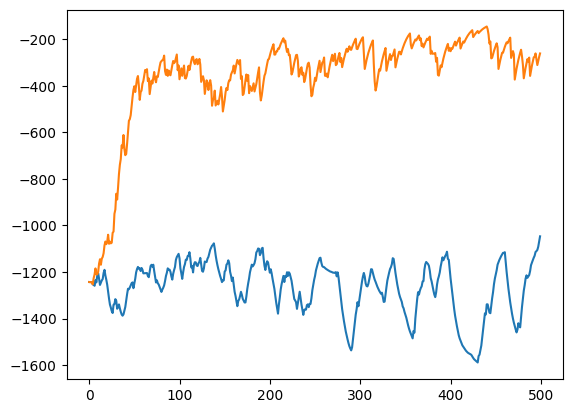

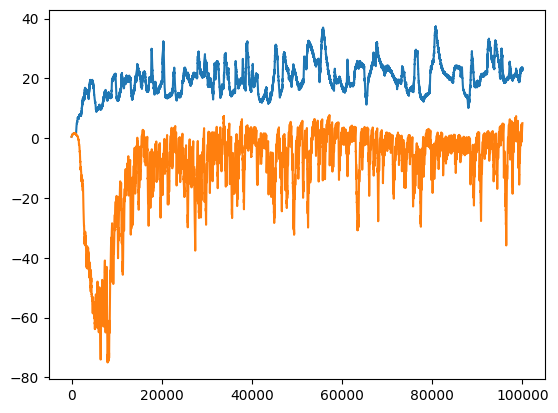

In [120]:
num_episodes = 500

agent1 = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)
reward_stat1, q_value_stat1 = train(agent1, num_episodes)
agent2 = DoubleDQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)
reward_stat2, q_value_stat2 = train(agent2, num_episodes)

plt.plot(range(len(reward_stat1)), moving_average(reward_stat1,10))
plt.plot(range(len(reward_stat2)), moving_average(reward_stat2,10))
plt.show()
plt.plot(range(len(q_value_stat1)), moving_average(q_value_stat1,200))
plt.plot(range(len(q_value_stat2)), moving_average(q_value_stat2,200))
plt.show()


In [123]:
test(agent1,1)
test(agent2,1)
